# Exercises

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF?

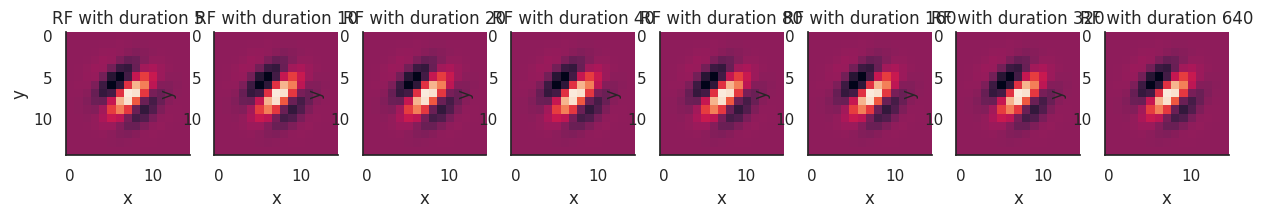

In [4]:
# set up

stimulus_durations = np.array([5, 10, 20, 40, 80, 160, 320, 640]) #s

plt.figure(figsize=(15,2))

for i, duration in enumerate(stimulus_durations):

  dt = .1
  std_dev = 1
  vf_size = (15,15)
  n_bins = round(duration / float(dt))
  S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

  # create receptive field
  size = vf_size # size in pixel of our receptive field
  mu = (8, 8) # center of the gabor pathc
  sigma = (4,4) #size of the gabor patch
  angle = 45 # orientation of the gabor patch
  frequency = .085 # spatial frequency of the gabor patch
  phase = 0 # pahse of the gabor pathc

  xx, yy = np.meshgrid(1. + np.arange(size[0]),
                          1. + np.arange(size[1]))

  # Gaussian envelope
  G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
              - np.power(yy - mu[1], 2) / (2. * sigma[1]))

  # spatial modulation
  phi = np.deg2rad(angle)
  xxr = xx * np.cos(phi)
  yyr = yy * np.sin(phi)
  xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
  Sn = np.cos(xyr + phase)

  K = G * Sn
  K /= np.amax(np.abs(K))

  plt.subplot(1,len(stimulus_durations),i+1)
  plt.imshow(K)
  plt.title(r'RF with duration {}'.format(duration))
  plt.xlabel('x')
  plt.ylabel('y')

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier.




## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates?